In [90]:
#Running thermal conductivity notebook first b/c I call some of the functions
%run 0_gpCAM-Physics-compare-Exp-data.ipynb

[True, True, True, True]
[False, False, False, False]
[False, False, False, True]
[False, False, False, False]
[False, False, False, True]
[False, False, False, False]
[False, False, False, False]
[False, False, False, True]
[False, False, False, False]
[False, False, False, False]
[False, False, False, True]
[False, False, False, False]
[False, False, False, False]
[False, False, False, False]
[False, False, False, True]
[False, False, False, True]
[False, False, False, True]
[False, False, False, True]
[False, False, False, True]
[False, False, False, True]
[False, False, False, True]
[False, False, False, True]
[False, False, False, True]
[False, False, False, False]
[False, False, False, True]
[False, False, False, True]
[False, False, False, True]
[False, False, False, True]
[False, False, False, True]
[False, False, False, True]
[False, False, False, True]
[False, False, False, False]
[False, False, False, False]
[False, False, False, True]
[False, False, False, True]
[False, Fal

KeyboardInterrupt: 

aks() initiated with hyperparameters: [1. 1. 1. 1. 1. 1. 1. 1.]
optimization method:  global
bounds:  None
finding objective function maxima...
optimization method  global
adjusted tolerance:  1e-05
population size:  20
maximum number of iterations:  20
bounds: 
[[0. 1.]
 [0. 1.]
 [0. 1.]]
cost function parameters:  None
differential_evolution step 1: f(x)= -0.847704
differential_evolution step 2: f(x)= -0.889891
differential_evolution step 3: f(x)= -0.891834
differential_evolution step 4: f(x)= -0.891834
differential_evolution step 5: f(x)= -0.893455
differential_evolution step 6: f(x)= -0.893455
differential_evolution step 7: f(x)= -0.893455
differential_evolution step 8: f(x)= -0.897375
differential_evolution step 9: f(x)= -0.897375
differential_evolution step 10: f(x)= -0.897375
differential_evolution step 11: f(x)= -0.899521
differential_evolution step 12: f(x)= -0.899521
differential_evolution step 13: f(x)= -0.900706
differential_evolution step 14: f(x)= -0.900706
differential_e

103
{'x': array([[0.25, 0.4 , 0.35, 0.  ]]), 'f(x)': array([2.17289211])}
104
{'x': array([[0.25, 0.45, 0.3 , 0.  ]]), 'f(x)': array([2.09750037])}
105
{'x': array([[0.25, 0.5 , 0.25, 0.  ]]), 'f(x)': array([2.08066614])}
106
{'x': array([[0.25, 0.55, 0.2 , 0.  ]]), 'f(x)': array([2.13041447])}
107
{'x': array([[0.25, 0.6 , 0.15, 0.  ]]), 'f(x)': array([2.25672082])}
108
{'x': array([[0.25, 0.65, 0.1 , 0.  ]]), 'f(x)': array([2.46675299])}
109
{'x': array([[0.25, 0.7 , 0.05, 0.  ]]), 'f(x)': array([2.75899731])}
110
{'x': array([[0.25, 0.75, 0.  , 0.  ]]), 'f(x)': array([3.11825475])}
111
{'x': array([[0.3, 0. , 0.7, 0. ]]), 'f(x)': array([4.62676277])}
112
{'x': array([[0.3 , 0.05, 0.65, 0.  ]]), 'f(x)': array([4.1564625])}
113
{'x': array([[0.3, 0.1, 0.6, 0. ]]), 'f(x)': array([3.69981032])}
114
{'x': array([[0.3 , 0.15, 0.55, 0.  ]]), 'f(x)': array([3.27700242])}
115
{'x': array([[0.3, 0.2, 0.5, 0. ]]), 'f(x)': array([2.90320456])}
116
{'x': array([[0.3 , 0.25, 0.45, 0.  ]]), 'f(x)'

FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/sarker/Documents/Document/gaussian_marcus/Physics-Matminer/Physics-based-GPR/figure/XFeSb_feature_GPR_prediction_s20.csv'

In [289]:
from scipy.optimize import curve_fit, minimize

## Import and Clean Data

In [290]:
#Drops any rows with NaN values
def fetch_sigmae0_dataframe(datafile):
    sigmae0_df = pd.read_csv(datafile)
    sigmae0_df = pd.DataFrame.dropna(sigmae0_df)
    sigmae0_df.replace(1.0, 9.999999E-01, inplace = True)
    return sigmae0_df

#Gets the endmember sigmae0 values
def fetch_endmember_values(sig_df):
    col_list = list(sig_df.columns)
    col_list.pop(0)
    col_list.remove('Sigma_E0')
    x_value = float(sig_df.loc[sig_df[col_list[0]] > 9.99e-01]['Sigma_E0'])
    y_value = float(sig_df.loc[sig_df[col_list[1]] > 9.99e-01]['Sigma_E0'])
    z_value = float(sig_df.loc[sig_df[col_list[2]] > 9.99e-01]['Sigma_E0'])
    return [x_value, y_value, z_value]

#Splits the dataframe for each binary system
def split_binary_data(sig_df):
    '''
    Inputs:
    c : array of molar fractions
    
    bin_list = [B-C, A-C, A-B]
    '''
    #Split up data for each binary system
    bin_list = []
    for comp in sig_df.columns[1:4]:
        binary = sig_df.loc[sig_df[comp] == 0.0]
        bin_list.append(binary)                
    return bin_list

# Mean function: Alloy Sigma_E0 Model

In [291]:
#Constants
e = 1.602e-19
m_e = 9.109e-31
hbar = 1.045e-34
kb = 1.38e-23


#Temperature = 300 K 
T = 300

#Doping Type : n
dpg = 'n'
#Material properties inputs
mat_props = {'formula': ['HfNiSn', 'TiNiSn', 'ZrNiSn'], 'BulkMod': [105E9, 122E9, 152E9],\
     'mpid': ['mp-20523', 'mp-924130', 'mp-30806'],\
     'AtmV' : [1.91E-29, 1.755E-29, 1.93E-29]}
    
#Binary sigmaE0 model
def binary_sigma_e0_model(c, U, d_h_pair, mat_props, dpg, T = 300):
    sigmae0_vegard = mat_props['sigma_endpts'][d_h_pair[0]] * c +\
    mat_props['sigma_endpts'][d_h_pair[1]] * (1-c)
    
    Cl = mat_props['BulkMod'][d_h_pair[0]] * c + mat_props['BulkMod'][d_h_pair[1]] * (1-c)
    
    AtmV = mat_props['AtmV'][d_h_pair[0]] * c + mat_props['AtmV'][d_h_pair[1]] * (1-c)
    
    A = (3 * math.pi**2 * c * (1-c) * Cl * AtmV) / (8 * kb * T)
    sigma_e0 = sigmae0_vegard * (1 / (1 + A * U))
    return sigma_e0

#Fit binary U value
def fit_binary_U_endpts(data_df, D_key, d_h_pair, mat_props, dpg, T = 300, p0 = 0):
    in_list = np.array(data_df[D_key])
    out_list = list(data_df['Sigma_E0'])
    U, cov = curve_fit(lambda C, U: binary_sigma_e0_model(C, U, d_h_pair, mat_props, dpg, T), in_list, out_list,\
                       p0 = p0, bounds = (0,np.inf))
    return U[0], cov

#Fit binary U for all systems in bin_list
def fit_binary_U_list(bin_list, mat_props, d_key_list =  ['TiNiSn', 'HfNiSn', 'HfNiSn'],\
                      d_h_pairs = [[1,2],[0,2],[0,1]], T = 300, p0 = 0):
    '''
    Inputs:
        bin_list: data separated by binary system
        mat_props: dictionary of material properties
        d_key_list: names of the columns specifying the composition
        d_h_pairs: shouldn't have to change this. this just specifies the 
        order of the binary systems in bin_list, should always be [B-C, A-C, A-B]
    Output:
        U_list: []
    '''
    U_list = []
    for b in [0,1,2]:
        u, cov = fit_binary_U_endpts(bin_list[b], d_key_list[b],\
                                         d_h_pairs[b],\
                                         mat_props, 'n', T = T, p0 = 0)
        U_list.append(u)    
    return U_list

#Excess sigmaE0 function --> for Muggianu model
def binary_exc_sigma_e0_endpts(c, U, d_h_pair, mat_props, dpg, T = 300):
    sigmae0_vegard = mat_props['sigma_endpts'][d_h_pair[0]] * c +\
    mat_props['sigma_endpts'][d_h_pair[1]] * (1-c)
    
    Cl = mat_props['BulkMod'][d_h_pair[0]] * c + mat_props['BulkMod'][d_h_pair[1]] * (1-c)
    
    AtmV = mat_props['AtmV'][d_h_pair[0]] * c + mat_props['AtmV'][d_h_pair[1]] * (1-c)
    
    A = (3 * math.pi**2 * c * (1-c) * Cl * AtmV) / (8 * kb * T)
    sigma_e0_exc = sigmae0_vegard * (1 / (A * U))
    return sigma_e0_exc 

#Muggianu model for ternary sigma_e0
def muggianu_model_sige0(U_list, mat_props, dpg, c, T = 300):
    '''
    Calculate excess sigma_e0 term by substracting off the Vegard's law value

    Inputs:
        U_list : array of pairwise alloy scattering U coefficients
        Will these be symmetric such that U_ij = U_ji?
        Kind of depends on what the "host" bandstructure is?
    NOTE: calculates based on the binary sigma_e0 value. Chooses binary composition
    based on the geometry of the Muggianu diagram
    U_list = [B-C, A-C, A-B]
    
    Output:
    1 / rho_final : final ternary sigma_e0 prediction
    '''
    c = np.array(c)
    c = np.where(c==1.0, 9.999999E-01, c)
    c = np.where(c==0.0, 1e-10, c)    
    c = list(c)
    c.append((1 + 1e-10) - sum(c))
    bin3 = [((1 + c[0] - c[1]) / 2) , ((1 + c[1] - c[0]) / 2)]
    bin2 = [((1 + c[0] - c[2]) / 2) , ((1 + c[2] - c[0]) / 2)]
    bin1 = [((1 + c[1] - c[2]) / 2) , ((1 + c[2] - c[1]) / 2)]
    excess3 = (1/ binary_exc_sigma_e0_endpts(bin3[0], U_list[2], [0,1], mat_props, dpg, T))
    excess2 = (1/ binary_exc_sigma_e0_endpts(bin2[0], U_list[1], [0,2], mat_props, dpg, T))
    excess1 = (1/ binary_exc_sigma_e0_endpts(bin1[0], U_list[0], [1,2], mat_props, dpg, T))
    comp_coeff = []
    for j,k in zip([1,0,0],[2,2,1]):
        comp_coeff.append((4 * c[j] * c[k]) / ((1 + c[j] - c[k]) * (1 + c[k] - c[j])))
    rho_excess = (excess3 * comp_coeff[2] + excess2 * comp_coeff[1] + excess1 * comp_coeff[0])
    inv_sig_vegard = 1 / (sum([conc * sig for conc, sig in zip(c, mat_props['sigma_endpts'])]))
    rho_final = inv_sig_vegard + rho_excess
    return 1 / rho_final

#Test
c = [0.0, 0.0]
sig_df = fetch_sigmae0_dataframe('input_data/XNiSn_gauss_data_purple.csv')
sig_endpts = fetch_endmember_values(sig_df)
mat_props['sigma_endpts'] = sig_endpts
bin_list = split_binary_data(sig_df)
U_list = fit_binary_U_list(bin_list, mat_props)
sig_tern = muggianu_model_sige0(U_list, mat_props, 'n', c, T = 300)
print(sig_tern)
print(U_list)

110569.38858237542
[0.0005290548104114843, 0.0002807694194924938, 0.00014452379450934875]


## Wrapper Functions for sigmaE0 model

Need to write wrapper around the above model so that the inputs are (composition, hyperparameters)
Run above functions to get U_list first
Should probably make U_list 3 different hyperparameters eventually

In [292]:
def run_muggianu_array_sigmae0(gp_obj, C, hps):
    sig_tern = np.empty((len(C)))
    for i in range(len(C)):
        sig_tern[i] = muggianu_model_sige0(U_list, mat_props, dpg, C[i], T)
    return sig_tern

## Hyperparameter Initialization

In [315]:
index_set_bounds = np.array([[0., 1.], [0., 1.]])
#hyperparameter_bounds = np.array([[0.0001, 1e7], [0.0001, 100]])
'''
Last three hyperparameters are for the binary U values. Could also fit these to the binary data instead of
treating as hyperparameters.
'''
hyperparameter_bounds = np.array([[0.0001,1e10],[0.0001, 10000]])
likelihood_optimization_method = "global"
likelihood_optimization_max_iter = 120
likelihood_optimization_pop_size = 100
likelihood_optimization_tolerance = 0.000001
hps_guess = np.array([100000, 1])

## Initialize and Train the GP Optimizer

In [316]:
'''
x : composition inputs
y : output sigma_e0 values
v : variance, currently assuming 5% variance on the experimental inputs
'''
x = np.array([[sig_df['HfNiSn'][i], sig_df['TiNiSn'][i]] for i in sig_df.index])
y = np.array([[sig_df['Sigma_E0'][i]] for i in sig_df.index])
v = y * 0.05 

print(x)
print(y)

[[0.        0.       ]
 [0.        0.1      ]
 [0.        0.5      ]
 [0.1       0.       ]
 [0.4       0.       ]
 [0.5       0.       ]
 [0.5       0.2      ]
 [0.5       0.3      ]
 [0.6       0.       ]
 [0.7       0.       ]
 [0.8       0.       ]
 [1.        0.       ]
 [0.        0.9999999]
 [0.05      0.95     ]
 [0.2       0.8      ]]
[[110569.3886  ]
 [114723.4397  ]
 [ 63378.92041 ]
 [107439.2636  ]
 [ 88002.24138 ]
 [ 82423.01234 ]
 [ 81809.0958  ]
 [ 81809.0958  ]
 [ 85158.4292  ]
 [ 72348.14731 ]
 [ 93747.98169 ]
 [ 85915.      ]
 [ 83240.65925 ]
 [116606.250112]
 [ 69412.      ]]


In [317]:
gp = GPOptimizer(2, 1, 1, index_set_bounds)

gp.tell(x, y, v)
gp.init_gp(hps_guess,
           gp_kernel_function=kernel_l2_single_task,
           gp_mean_function=run_muggianu_array_sigmae0)
gp.train_gp(hyperparameter_bounds)

fvGP training started with  15  data points
Hyper-parameter tuning in progress. Old hyper-parameters:  [100000      1]  with old log likelihood:  251584.5032165012
I am performing a global differential evolution algorithm to find the optimal hyperparameters.
maximum number of iterations:  120
termination tolerance:  1e-06
bounds:  [[1.e-04 1.e+10]
 [1.e-04 1.e+04]]
differential_evolution step 1: f(x)= 240967
differential_evolution step 2: f(x)= 87245.2
differential_evolution step 3: f(x)= 87245.2
differential_evolution step 4: f(x)= 87245.2
differential_evolution step 5: f(x)= 11239.7
differential_evolution step 6: f(x)= 11239.7
differential_evolution step 7: f(x)= 1549.93
differential_evolution step 8: f(x)= 178.532
differential_evolution step 9: f(x)= 178.532
differential_evolution step 10: f(x)= 178.532
differential_evolution step 11: f(x)= 178.532
differential_evolution step 12: f(x)= 178.532
differential_evolution step 13: f(x)= 178.532
differential_evolution step 14: f(x)= 178.53

array([2.09476717e+09, 2.65167222e-01])

## Prediction posterior mean

In [318]:
#Get the input composition values for the ternary 
from ternary.helpers import simplex_iterator, normalize
P = []
Q = []
R = []
t = []
for e, f, g in simplex_iterator(scale=20, boundary=True):
    p, q, r = normalize([e, f, g])
    t.append((p, q, r))
    P.append(p)
    Q.append(q)
    R.append(r)

In [319]:
#Ask for new points based on maximum uncertainty
#Doesn't give a real point? How to indicate to the algorithm that c_x + c_y + c_z = 1?
gp.ask(n = 3)

aks() initiated with hyperparameters: [2.09476717e+09 2.65167222e-01]
optimization method:  global
bounds:  None
finding objective function maxima...
optimization method  global
adjusted tolerance:  1e-05
population size:  20
maximum number of iterations:  20
bounds: 
[[0. 1.]
 [0. 1.]]
cost function parameters:  None
differential_evolution step 1: f(x)= -45705.9
differential_evolution step 2: f(x)= -45729.4
differential_evolution step 3: f(x)= -45729.4
differential_evolution step 4: f(x)= -45729.4
differential_evolution step 5: f(x)= -45729.4
differential_evolution step 6: f(x)= -45730.9
differential_evolution step 7: f(x)= -45730.9
differential_evolution step 8: f(x)= -45731
differential_evolution step 9: f(x)= -45732.2
differential_evolution step 10: f(x)= -45732.2
differential_evolution step 11: f(x)= -45732.8
differential_evolution step 12: f(x)= -45732.8
differential_evolution step 13: f(x)= -45732.8
differential_evolution step 14: f(x)= -45733.3
differential_evolution step 15: f

{'x': array([[0.99997997, 0.99987195]]), 'f(x)': array([-45733.51413803])}

In [320]:
#run 
counter = 0
l = np.empty((len(P), 4))
for i in range(len(P)):
    res = gp.gp.posterior_mean(np.array([[P[i], Q[i]]]))
    l[counter, 0] = P[i]
    l[counter, 1] = Q[i]
    l[counter, 2] = R[i]
    l[counter, 3] = res["f(x)"]  #no obj
    counter += 1
print(l)

[[0.00000000e+00 0.00000000e+00 1.00000000e+00 1.10569192e+05]
 [0.00000000e+00 5.00000000e-02 9.50000000e-01 1.15712323e+05]
 [0.00000000e+00 1.00000000e-01 9.00000000e-01 1.14723319e+05]
 [0.00000000e+00 1.50000000e-01 8.50000000e-01 1.08485119e+05]
 [0.00000000e+00 2.00000000e-01 8.00000000e-01 9.97093509e+04]
 [0.00000000e+00 2.50000000e-01 7.50000000e-01 9.05497097e+04]
 [0.00000000e+00 3.00000000e-01 7.00000000e-01 8.21728070e+04]
 [0.00000000e+00 3.50000000e-01 6.50000000e-01 7.51425588e+04]
 [0.00000000e+00 4.00000000e-01 6.00000000e-01 6.96694730e+04]
 [0.00000000e+00 4.50000000e-01 5.50000000e-01 6.57720980e+04]
 [0.00000000e+00 5.00000000e-01 5.00000000e-01 6.33789160e+04]
 [0.00000000e+00 5.50000000e-01 4.50000000e-01 6.24548390e+04]
 [0.00000000e+00 6.00000000e-01 4.00000000e-01 6.32410382e+04]
 [0.00000000e+00 6.50000000e-01 3.50000000e-01 6.60766626e+04]
 [0.00000000e+00 7.00000000e-01 3.00000000e-01 7.12810402e+04]
 [0.00000000e+00 7.50000000e-01 2.50000000e-01 7.893205

## Plot ternary diagrams

In [321]:
#Save data to output file
file_name = "output_data/XNiSn_sigE0_GPR_prediction_s20.csv"

np.savetxt(file_name,
           l,
           delimiter=",",
           header='HfNiSn, TiNiSn, ZrNiSn, mean_noObj')

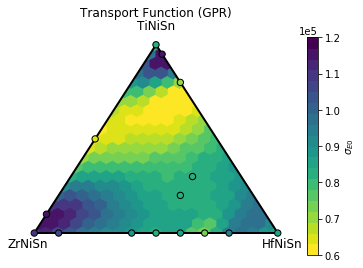

In [326]:
# Arrange data as dictionary

def convert_to_dict(data_array, scale):
    data_dict = {}
    for (x, y, z, v) in data_array:
        data_dict[(x * scale, y * scale, z * scale)] = v
    return data_dict


def plot_system(pred_dict, data_df = None, vmin = None, vmax = None, scale = 20, title_label = 'Transport Function (GPR)\n',\
                axis_labels = ['HfNiSn', 'TiNiSn', 'ZrNiSn'], save = False, outfile = None):   
    figure, tax = ternary.figure(scale=scale)
    fontsize = 12
    tax.set_title(title_label, fontsize=fontsize)
    tax.right_corner_label(axis_labels[0], fontsize=fontsize, position = (0.95, 0.04, 0))  
    tax.top_corner_label(axis_labels[1], fontsize=fontsize) 
    tax.left_corner_label(axis_labels[2], fontsize=fontsize, position = (0, 0.04, 0))  #Bottom label
    tax.get_axes().axis('off')
    tax.heatmap(pred_dict,
                 style="hexagonal",
                 cbarlabel = r'$\sigma_{E0}$', vmin = vmin, vmax = vmax,
                 cmap=plt.cm.get_cmap('viridis_r', 20),
                    scientific = True)
    tax.boundary(linewidth = 2.0)
    if data_df is not None:
        Xt = [(data_df[axis_labels[0]][i] * scale, data_df[axis_labels[1]][i] * scale,\
               data_df[axis_labels[2]][i] * scale)\
              for i in  list(data_df.index)]
        St = data_df['Sigma_E0']
        tax.scatter(Xt, c = list(St), cmap=plt.cm.get_cmap('viridis_r', 20),scientific = True, s = 40,\
                    vmin = vmin, vmax = vmax, edgecolors = 'k', zorder = 10, clip_on = False)
    if save and outfile:
        tax.savefig(outfile, bbox_inches = 'tight')

pred_dict = convert_to_dict(l, 20)
plot_system(pred_dict, sig_df, vmin = 60000, vmax = 120000, save = True, outfile = 'output_data/XNiSn_sigE0_GPR_pred.pdf')

## Evaluate and Plot Uncertainty (Covariance)

In [327]:
counter = 0
unc = np.empty((len(P), 4))
for i in range(len(P)):
    res = gp.gp.posterior_covariance(np.array([[P[i], Q[i], R[i]]]))
    unc[counter, 0] = P[i]
    unc[counter, 1] = Q[i]
    unc[counter, 2] = R[i]
    unc[counter, 3] = np.sqrt(res["v(x)"])  #no obj
    counter += 1
print(l)

filename = 'XNiSn_sige0_GPR_cov_s20.csv'

np.savetxt(file_name,
           unc,
           delimiter=",",
           header='HfNiSn, TiNiSn, ZrNiSn, uncertainty')


[[0.00000000e+00 0.00000000e+00 1.00000000e+00 1.10569192e+05]
 [0.00000000e+00 5.00000000e-02 9.50000000e-01 1.15712323e+05]
 [0.00000000e+00 1.00000000e-01 9.00000000e-01 1.14723319e+05]
 [0.00000000e+00 1.50000000e-01 8.50000000e-01 1.08485119e+05]
 [0.00000000e+00 2.00000000e-01 8.00000000e-01 9.97093509e+04]
 [0.00000000e+00 2.50000000e-01 7.50000000e-01 9.05497097e+04]
 [0.00000000e+00 3.00000000e-01 7.00000000e-01 8.21728070e+04]
 [0.00000000e+00 3.50000000e-01 6.50000000e-01 7.51425588e+04]
 [0.00000000e+00 4.00000000e-01 6.00000000e-01 6.96694730e+04]
 [0.00000000e+00 4.50000000e-01 5.50000000e-01 6.57720980e+04]
 [0.00000000e+00 5.00000000e-01 5.00000000e-01 6.33789160e+04]
 [0.00000000e+00 5.50000000e-01 4.50000000e-01 6.24548390e+04]
 [0.00000000e+00 6.00000000e-01 4.00000000e-01 6.32410382e+04]
 [0.00000000e+00 6.50000000e-01 3.50000000e-01 6.60766626e+04]
 [0.00000000e+00 7.00000000e-01 3.00000000e-01 7.12810402e+04]
 [0.00000000e+00 7.50000000e-01 2.50000000e-01 7.893205

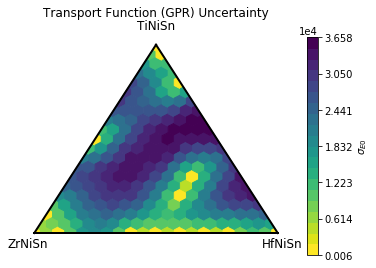

In [328]:
cov_dict = convert_to_dict(unc, 20)
plot_system(cov_dict, title_label = 'Transport Function (GPR) Uncertainty\n',save = True,\
            outfile = 'output_data/XNiSn_sigE0_GPR_cov.pdf')